Demo of the method proposed in *Optimizing Kernel Ridge Regression for Remote Sensing problems (2018)*. 

### Generate some random data

In [1]:
# import os
# os.environ["KERAS_BACKEND"]="tensorflow"
import numpy as np
import keras_okrr
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

#np.random.seed(2034)
np.random.seed(2030)
M = 5
N = 400
lda = 0.001
gamma_inicial = np.float64(1)

def true_func(x_t):
    return np.cos(x_t)*np.abs(x_t)

X = (np.random.rand(N,1)*2*np.pi-np.pi)
y = true_func(X[:,0])+.1*np.random.randn(N)

sel =np.random.choice(len(X),M)
X_u = X[sel]
y_u = y[sel]

X.shape,y.shape,X_u.shape,y_u.shape

/home/gonzalo/miniconda3/envs/p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


((400, 1), (400,), (5, 1), (5,))

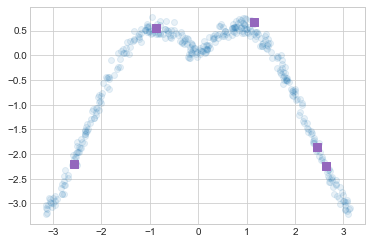

In [2]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(X,y,alpha=.1)
ax.scatter(X_u,y_u,s=80,c="C4",marker="s")

## Full KRR

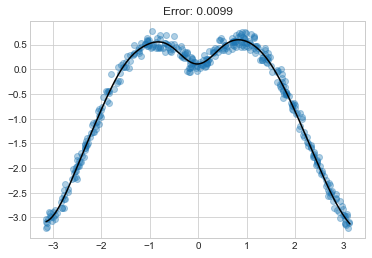

In [3]:
_,alpha_full,err_train = keras_okrr.krr_numpy(X,y,gamma_inicial,lda)
Kfu = keras_okrr.k_test_numpy(X,X,gamma_inicial)

pred_funct_full = lambda x_t:keras_okrr.k_test_numpy(X,x_t[:,np.newaxis],gamma_inicial).dot(alpha_full).squeeze()

err_train_full = mean_squared_error(y,pred_funct_full(X.squeeze()))

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(X,y,alpha=.35)
ax.plot(np.arange(-np.pi,np.pi,.01),pred_funct_full(np.arange(-np.pi,np.pi,.01)),c="black")
    
_ = ax.set_title("Error: %.4f"%err_train_full)
# fig.savefig(os.path.join(folder_okrr_slides,"krr_full.pdf"),bbox="tight")

### Apply *standard* KRR using a subset of `M` points

In [4]:
def plot_xy(x_r,y_r,pred_func,X,y,true_func=true_func):
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    ax.scatter(X,y,alpha=.35)
    ax.scatter(x_r,y_r,s=80,c="C4",marker="s")
    ax.plot(np.arange(-np.pi,np.pi,.01),pred_func(np.arange(-np.pi,np.pi,.01)),c="C4")
    
    ax.plot(np.arange(-np.pi,np.pi,.01),pred_funct_full(np.arange(-np.pi,np.pi,.01)),c="black")
    return fig,ax


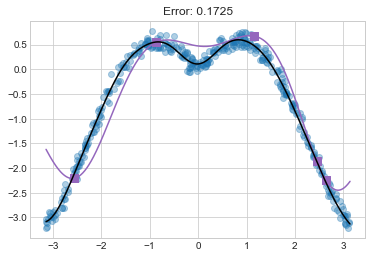

In [5]:
_,alpha_sod,err_train = keras_okrr.krr_numpy(X_u,y_u,gamma_inicial,lda)

pred_funct_sod = lambda x_t:keras_okrr.k_test_numpy(X_u,x_t[:,np.newaxis],gamma_inicial).dot(alpha_sod).squeeze()

err_train_sod = mean_squared_error(y,pred_funct_sod(X.squeeze()))

fig,ax = plot_xy(X_u,y_u,pred_funct_sod,X,y)
_ = ax.set_title("Error: %.4f"%err_train_sod)

## Nyström method

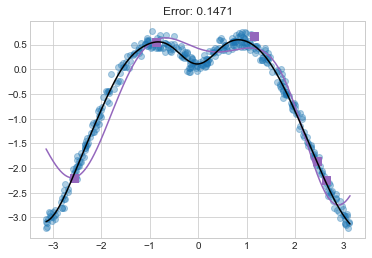

In [6]:
Kuu = keras_okrr.k_test_numpy(X_u,X_u,gamma_inicial)
Kfu = keras_okrr.k_test_numpy(X_u,X,gamma_inicial)
alpha_nystrom = np.linalg.solve(Kfu.T.dot(Kfu) + lda*Kuu,Kfu.T.dot(y))
pred_funct_nystrom = lambda x_t:keras_okrr.k_test_numpy(X_u,x_t[:,np.newaxis],gamma_inicial).dot(alpha_nystrom).squeeze()
fig,ax = plot_xy(X_u,y_u,pred_funct_nystrom,X,y)
err_train_nystrom = mean_squared_error(y,pred_funct_nystrom(X.squeeze()))
_ = ax.set_title("Error: %.4f"%err_train_nystrom)

### Optimize the centroids using *mini-batch gradient descent*

Last loss: 0.0233


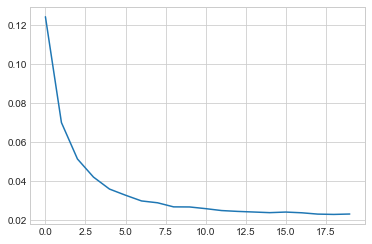

In [7]:
from keras.optimizers import Adam
model = keras_okrr.model_all_gd(X_u,y_u,
                                init_gamma=gamma_inicial,
                                lmbda_init=lda,
                                regularize_alpha_layer=True,
                                optimizer=Adam(lr=.005))

nb_epoch = 20
history = model.fit(X,
                    y[:,np.newaxis],
                    batch_size=8,
                    epochs=nb_epoch,verbose=0)

plt.plot(history.epoch,history.history["mean_squared_error"])
print("Last loss: %.4f"%history.history["mean_squared_error"][-1])

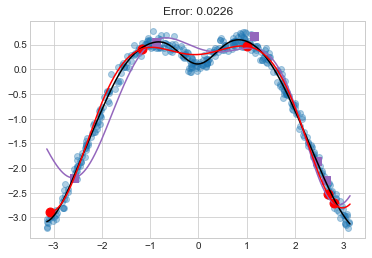

In [8]:
x_opt,gamma_opt = model.get_layer("k_test").get_weights()
alpha_opt = model.get_layer("alpha").get_weights()
alpha_opt = alpha_opt[0]
K_opt = keras_okrr.k_test_numpy(x_opt,x_opt,gamma_opt)
y_opt = K_opt.dot(alpha_opt)

fig,ax = plot_xy(X_u,y_u,pred_funct_nystrom,X,y)

points_x = np.arange(-np.pi,np.pi,.01)
pred_funct_okrr = lambda x_t:keras_okrr.k_test_numpy(x_opt,x_t[:,np.newaxis],
                                                     gamma_opt).dot(alpha_opt).squeeze()


ax.scatter(x_opt,y_opt,c="red",s=80)
ax.plot(points_x,model.predict(points_x[:,np.newaxis]).squeeze(),
        c="red")
err_train_nystrom = mean_squared_error(y,pred_funct_okrr(X.squeeze()))
_ = ax.set_title("Error: %.4f"%err_train_nystrom)

assert np.max(np.abs(model.predict(points_x[:,np.newaxis]).squeeze()-pred_funct_okrr(points_x))) < 1e-7, "model predict doesn't work as expected"



#   Copyright & Disclaimer


The programs contained in this package are granted free of charge for
   research and education purposes only. Scientific results produced using
   the software provided shall acknowledge the use of this implementation
   provided by us. If you plan to use it for non-scientific purposes,
   don't hesitate to contact us. Because the programs are licensed free of
   charge, there is no warranty for the program, to the extent permitted
   by applicable law. except when otherwise stated in writing the
   copyright holders and/or other parties provide the program "as is"
   without warranty of any kind, either expressed or implied, including,
   but not limited to, the implied warranties of merchantability and
   fitness for a particular purpose. the entire risk as to the quality and
   performance of the program is with you. should the program prove
   defective, you assume the cost of all necessary servicing, repair or
   correction. In no event unless required by applicable law or agreed to
   in writing will any copyright holder, or any other party who may modify
   and/or redistribute the program, be liable to you for damages,
   including any general, special, incidental or consequential damages
   arising out of the use or inability to use the program (including but
   not limited to loss of data or data being rendered inaccurate or losses
   sustained by you or third parties or a failure of the program to
   operate with any other programs), even if such holder or other party
   has been advised of the possibility of such damages.

   NOTE: This is just a demo providing a default initialization. Training
   is not at all optimized. Other initializations, optimization techniques,
   and training strategies may be of course better suited to achieve improved
   results in this or other problems.

 Copyright (c) 2017 by Gonzalo Mateo-Garcia
 
 gonzalo.mateo-garcia at **uv** DOT *es*
 
 https://www.uv.es/gonmagar
 
 http://isp.uv.es/
